In [5]:
import torch 
import gpytorch
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath('..'))
from pv_plot import plot_train_test_split, plot_grid
from data.utils import *
from data import PVDataGenerator, PVDataLoader
from models import MultitaskGPModel
from kernels import Kernel
from likelihoods.beta import MultitaskBetaLikelihood
from gpytorch.means import ZeroMean, ConstantMean

In [55]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 40
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 55
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [56]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    drop_nan=True)

X, y = generator.get_time_series()
num_latent = 5
num_tasks = y.shape[1]

==> Loading data
==> Loaded data in: 0 m : 15 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



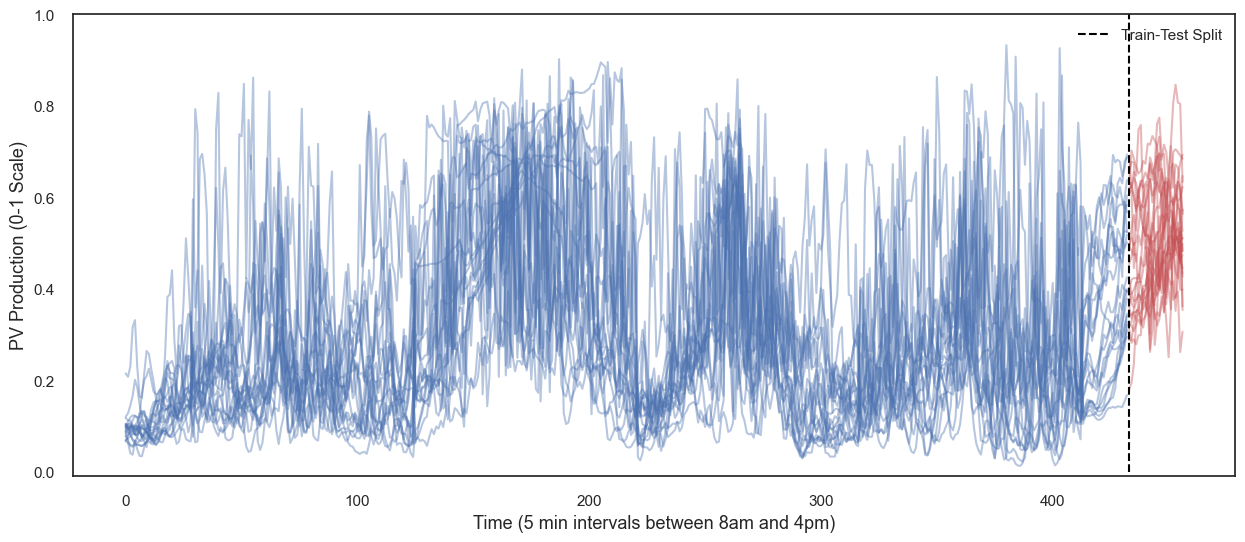

In [57]:
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=14,n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [58]:
mean = ConstantMean(batch_shape=torch.Size([num_latent]))
likelihood = MultitaskBetaLikelihood(num_tasks=num_tasks, scale=60)

kernel_module = Kernel(num_latent=num_latent)
matern_base = kernel_module.get_matern()
matern_quasi = kernel_module.get_matern()
periodic1 = kernel_module.get_periodic()

quasi_periodic = kernel_module.get_quasi_periodic(matern_base, matern_quasi, periodic1)


In [59]:
model = MultitaskGPModel(x_train=x_train,
                        y_train=y_train,
                        likelihood=likelihood,
                        mean_module=mean,
                        covar_module=quasi_periodic,
                        num_latents=num_latent)

In [60]:
model.fit(n_iter=500, lr=0.1, verbose=True)

Iter 50/500 - Loss: -11.94912052154541
Iter 100/500 - Loss: -16.258031845092773
Iter 150/500 - Loss: -17.28941535949707
Iter 200/500 - Loss: -18.019731521606445
Iter 250/500 - Loss: -18.347431182861328
Iter 300/500 - Loss: -18.57854652404785
Iter 350/500 - Loss: -18.72835922241211
Iter 400/500 - Loss: -18.8101806640625
Iter 450/500 - Loss: -18.905555725097656
Iter 500/500 - Loss: -18.90995979309082


In [48]:
def predict(model, x):
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(30):
        dist_tr = model.likelihood(model(x))
        mode = model.likelihood.mode().mean(axis=0)
        mean = dist_tr.mean.mean(axis=0)
        samples = dist_tr.sample(sample_shape=torch.Size([30]))
        median = samples.median(axis=0).values.mean(axis=0)
        lower, upper = np.percentile(samples, [2.5, 97.5], axis=0)
        lower = lower.mean(axis=0)
        upper = upper.mean(axis=0)
    return median, lower, upper, mean, mode


In [49]:
median_tr, lower_tr, upper_tr, mean_tr, mode_tr = predict(model, x_train)
median_te, lower_te, upper_te, mean_te, mode_te = predict(model, x_test)

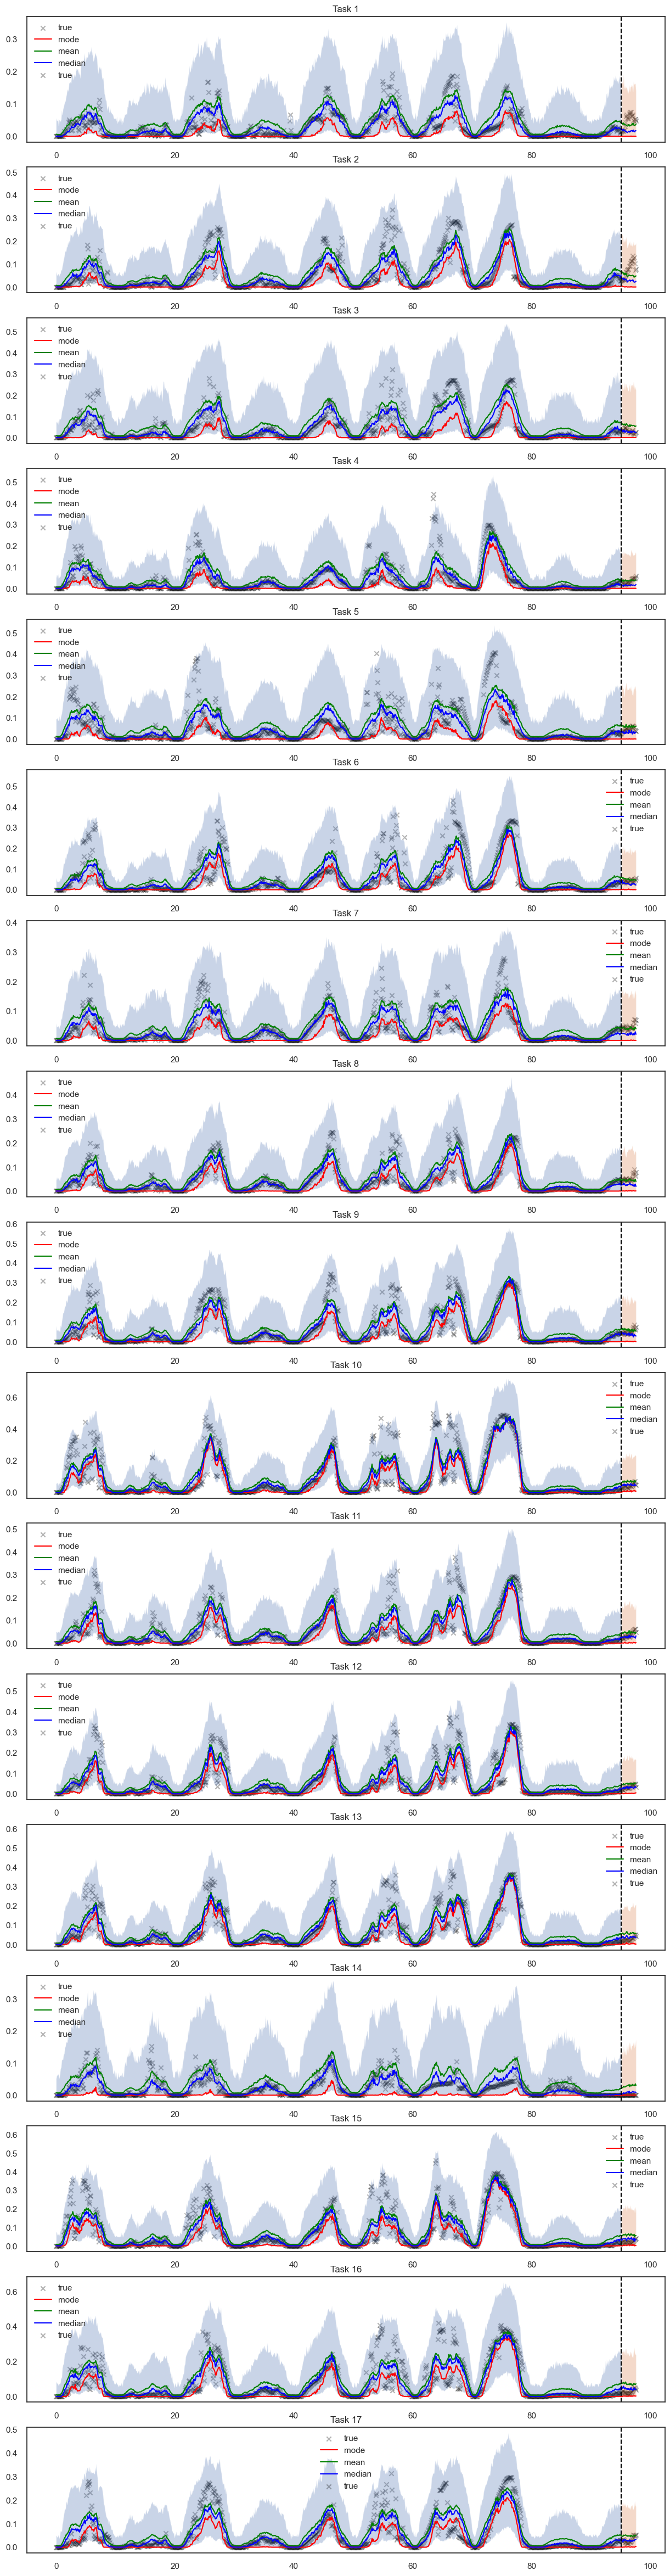

In [53]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(y.size(-1), 1, figsize=(15, 60))

for i in range(y.size(-1)):
    ax[i].scatter(x_train, y_train[:,i], label='true', marker='x', color='black', alpha=0.3)
    ax[i].plot(x_train, mode_tr[:,i], label='mode', color='red')
    ax[i].plot(x_train, mean_tr[:,i], label='mean', color='green')
    ax[i].plot(x_train, median_tr[:,i], label='median', color='blue')
    ax[i].fill_between(x_train, lower_tr[:,i], upper_tr[:,i], alpha=0.3)
    
    ax[i].scatter(x_test, y_test[:,i], label='true', marker='x', color='black', alpha=0.3)
    ax[i].plot(x_test, mode_te[:,i],color='red')
    ax[i].plot(x_test, mean_te[:,i], color='green')
    ax[i].plot(x_test, median_te[:,i], color='blue')
    ax[i].fill_between(x_test, lower_te[:,i], upper_te[:,i], alpha=0.3)
    
    # plot vertical lines for train/test split
    ax[i].axvline(x_train.max(), color='black', linestyle='--')

    ax[i].legend()
    ax[i].set_title(f'Task {i+1}')

In [54]:
model.likelihood.scale

tensor([[12.9941, 11.7987,  7.9671, 10.5945,  8.8328, 11.9995, 14.0637, 14.4823,
         11.5820, 12.2340, 14.5097, 14.4806, 13.5592,  9.9124, 12.3902,  9.6896,
         14.0027]], grad_fn=<SoftplusBackward0>)